In [38]:
import math
import random
from functools import reduce
from typing import Dict, Tuple, Set, List, Callable


class Item:
    def __init__(self, weight: int):
        self.weight = weight
    
    def __str__(self) -> str:
        return f"{self.weight}"

    def __repr__(self):
        return f"{self.weight}"


class Graph:
    def __init__(self, nodes: Dict[str, Set[str]], edges: Set[Tuple[str, str]]):
        """
        A graph object.

        Args:
            nodes (Dict[str, Set[str]]): A dictionary of nodes in the graph,
                mapping to a set of nodes a node is connected to.
            edges (Set[Tuple[str, str]]): The edges of the graph. Each tuple
                shows an edge in the graph.
        """
        self.nodes = nodes
        self.edges = edges



def create_bin_packing_graph(items: List[Item], bins: int) -> Graph:
    """
    Creates a graph to reflect a bin packing problem.

    "s" and "e" nodes are always created. Each node is created as "iXbY" where X
    is item's position in the list and Y is the bin index.

    Args:
        items (List[Item]): Number of items.
        bins (int): Number of bins to sort.

    Returns:
        (Graph): Graph object that contains the nodes and edges of the graph.
    """
    if (len(items) == 0):
        raise ValueError("No items to create nodes from.")

    if (bins == 0):
        raise ValueError("No bins to create nodes from.")

    nodes: Dict[str, Set[str]] = {}

    no_items = len(items)

    # Create nodes
    for i in range(no_items):
        for b in range(bins):
            nodes[f"i{i}b{b}"] = set()

    nodes["s"] = set()
    nodes["e"] = set()

    # Create links between nodes
    edges = set()

    ## Connect start node to initial next nodes
    for b in range(bins):
        nodes["s"].add(f"i0b{b}")
        edges.add(("s", f"i0b{b}"))
    
    for i in range(no_items):
        if i == no_items - 1:
            ## Connect to end node
            for b in range(bins):
                current_node = f"i{i}b{b}"
                
                nodes[current_node].add("e")
                edges.add((current_node, "e"))
        else:
            ## Connect to next item's nodes
            for pre_bin in range(bins):
                current_node = f"i{i}b{pre_bin}"

                for post_bin in range(bins):
                    next_node = f"i{i + 1}b{post_bin}"

                    nodes[current_node].add(next_node)
                    edges.add((current_node, next_node))

    return Graph(nodes, edges)


def convert_path_to_bins(items: List[Item], bins: int, path: List[str]) -> List[List[Item]]:
    """
    Converts a graph path into bins.

    Args:
        items (List[Item]): The list of items.
        bins (int): The number of bins we have.
        path (List[str]): The travelled nodes. Must start with 's' and end with 
            'e'. Path must start at item 0 (or the first item).

    Returns:
        (List[List[Item]]): A list of bins and their items.
    """
    if items is None or len(items) == 0:
        raise ValueError("Invalid items parameter given.")

    if bins == 0:
        raise ValueError("No bins given.")

    if path is None or len(path) == 0:
        raise ValueError("Invalid path given.")

    item_counter = 0
    bins = [ [] for _ in range(bins) ]

    # Ignore start and end nodes
    for node in path[1:-1]:
        item_bin = int(node.split('b')[1])
        item = items[item_counter]

        bins[item_bin].append(item)

        item_counter += 1

    return bins


def bin_weight(bin: List[Item]) -> int:
    """
    Get the total weight of a bin.

    Args:
        bin (List[Item]): List of bin items.

    Returns:
        (int): The total item weight.
    """
    if bin is None:
        raise ValueError("Bin was None.")

    weight = 0
    for item in bin:
        weight += item.weight

    return weight


def max_min_bin_diff_fitness(bins: List[List[Item]]) -> int:
    """
    Calculates the difference between the biggest and smallest bin. Can be used
    as a fitness function for ant colony optimisation.

    Args:
        bins (List[List[Item]]): A list of bins with items in.

    Returns:
        (int): The difference between the biggest and smallest bin.
    """
    smallest_bin: int = math.inf
    biggest_bin: int = 0

    for b in bins:
        weight = bin_weight(b)

        smallest_bin = weight if weight < smallest_bin else smallest_bin
        biggest_bin = weight if weight > biggest_bin else biggest_bin

    return biggest_bin - smallest_bin


def generate_paths_with_pheromones(graph: Graph, pheromone_table: Dict[Tuple[str, str], float], amount: int) -> List[List[str]]:
    """
    Generates a set of graph paths with a pheromone bias, paths with highest
    pheromone values are more likely to be travelled.

    Args:
        graph (Graph): The graph.
        pheromone_table (Dict[Tuple[str, str], float]): A dictionary mapping
            links between two nodes to a pheromone value.
        amount (int): The amount of paths to generate.

    Returns:
        (List[List[str]]): The generated paths.
    """
    paths = []

    for _ in range(amount):
        path = ["s"]
        current_node = "s"

        # Find the next node to travel
        while current_node != "e":
            possible_nodes = graph.nodes[current_node]
            next_node = None

            ## Create a table of "travel to node" probabilities
            pheromone_total = reduce(lambda sum, node: sum + pheromone_table[(current_node, node)], possible_nodes, 0)
            probability_table = []
            running_total = 0

            for node in possible_nodes:
                probability = pheromone_table[(current_node, node)] / pheromone_total
                running_total += probability
                probability_table.append((node, running_total))

            # TODO: Does this break sometimes because the final value may not be 1?

            ## Randomly choose which node to travel to
            random_number = random.random()

            for pair in probability_table:
                probability = pair[1]

                if random_number <= probability:
                    node = pair[0]

                    next_node = node
                    break

            ## Travel to the node
            path.append(next_node)
            current_node = next_node

        # Submit path
        paths.append(path)

    return paths


def get_bin_packing_ant_colony_best_fitness(graph: Graph, items: List[Item], bins: int, per_loop_limit: int, evaluation_limit: int, evaporation_rate: float, fitness_function: Callable[[List[List[Item]], int], int]) -> Tuple[List[str], int]:
    """
    Runs the ant colony optimisation (ACO) algorithm for bin packing
    and returns the best candidate path through the supplied nodes.

    Args:
        graph (Graph): The graph to evaluate.
        items (List[Item]): The items used for the bin packing problem.
        bins (int): The amount of bins to sort into.
        per_loop_limit (int): How many paths to traverse per loop before
            evaporation.
        evaluation_limit (int): Maximum number of fitness evaluations overall.
        evaporation_rate (float): The amount to reduce pheromones by after
            a loop of evaluations.
        fitness_function (Callable[[List[List[Item]], int]): A function that 
            takes a list of bins and returns a fitness value for optimisation.

    Returns:
        (Tuple[List[str], int]): A tuple of the path taken and the fitness
            value for it.
    """
    pheromone_table: Dict[Tuple[str, str], float] = {}
    total_evaluations = 0

    best_fitness = math.inf
    best_path: List[List[str]] = None

    while total_evaluations < evaluation_limit:
        # 1. Randomly distribute small amounts of pheromone.
        for edge in graph.edges:
            pheromone_table[edge] = 1 * random.random()

        # 2. Generate a set of ant paths from S (start) to E (end)
        paths = generate_paths_with_pheromones(graph, pheromone_table, per_loop_limit)

        # 3. Update the pheromone in your pheromone table for each ant’s path according to its fitness.
        for path in paths:
            bin_list = convert_path_to_bins(items, bins, path)
            fitness = fitness_function(bin_list)
            pheromone = 100 / fitness

            if fitness < best_fitness:
                best_fitness = fitness
                best_path = path

            ## Add the pheromone to each edge in the path
            for r in range(len(path) - 1):
                current_node = path[r]
                next_node = path[r + 1]

                pheromone_table[(current_node, next_node)] += pheromone

        # 4. Evaporate the pheromone for all links in the graph.
        for edge in graph.edges:
            pheromone_table[edge] *= 1 - evaporation_rate

        total_evaluations += per_loop_limit

    return best_path, best_fitness


def print_bins(bins: List[List[Item]]):
    for i in range(len(bins)):
        current_bin = bins[i]
        total = reduce(lambda sum, item: sum + item.weight, current_bin, 0)
        print(f"Bin {i + 1}:")
        print(f"{current_bin} = {total}")


In [8]:
import time

for trial in range(5):
    print(f"Trial {trial + 1}")
    
    items = [ Item(weight) for weight in range(1, 501) ]
    bins = 10
    per_loop_limit = 100
    path_limit = 10000
    evaporation_rate = 0.9
    
    start = time.time()
    graph = create_bin_packing_graph(items, bins)
    end = time.time()
    
    print(f"Created graph in {end - start} seconds")

    start = time.time()
    path, best_fitness = get_bin_packing_ant_colony_best_fitness(graph, items, bins, per_loop_limit, path_limit, evaporation_rate, max_min_bin_diff_fitness)
    end = time.time()
    
    print(f"Finished bin packing in {end - start} seconds")
    
#     print(path)

    print(f"Fitness: {best_fitness}")

#     bins = convert_path_to_bins(items, bins, path)
#     print_bins(bins)


Trial 1
Created graph in 0.03399777412414551 seconds
Finished bin packing in 37.73419237136841 seconds
Fitness: 1478
Trial 2
Created graph in 0.04100942611694336 seconds
Finished bin packing in 37.670525312423706 seconds
Fitness: 1662
Trial 3
Created graph in 0.05499601364135742 seconds
Finished bin packing in 36.491326332092285 seconds
Fitness: 1801
Trial 4
Created graph in 0.03199625015258789 seconds
Finished bin packing in 37.96271276473999 seconds
Fitness: 1731
Trial 5
Created graph in 0.0339970588684082 seconds
Finished bin packing in 38.761207580566406 seconds
Fitness: 1161


In [5]:
import time

for trial in range(5):
    print(f"Trial {trial + 1}")
    
    items = [ Item(weight) for weight in range(1, 501) ]
    bins = 10
    per_loop_limit = 100
    path_limit = 10000
    evaporation_rate = 0.5
    
    start = time.time()
    graph = create_bin_packing_graph(items, bins)
    end = time.time()
    
    print(f"Created graph in {end - start} seconds")

    start = time.time()
    path, best_fitness = get_bin_packing_ant_colony_best_fitness(graph, items, bins, per_loop_limit, path_limit, evaporation_rate, max_min_bin_diff_fitness)
    end = time.time()
    
    print(f"Finished bin packing in {end - start} seconds")
    
#     print(path)

    print(f"Fitness: {best_fitness}")

#     bins = convert_path_to_bins(items, bins, path)
#     print_bins(bins)


Trial 1
Created graph in 0.05199909210205078 seconds
Finished bin packing in 36.739078760147095 seconds
Fitness: 1149
Trial 2
Created graph in 0.03401017189025879 seconds
Finished bin packing in 36.79222106933594 seconds
Fitness: 1681
Trial 3
Created graph in 0.0340275764465332 seconds
Finished bin packing in 37.79443430900574 seconds
Fitness: 1166
Trial 4
Created graph in 0.048998355865478516 seconds
Finished bin packing in 37.20328140258789 seconds
Fitness: 1623
Trial 5
Created graph in 0.03299903869628906 seconds
Finished bin packing in 38.89953923225403 seconds
Fitness: 1426


In [9]:
import time

for trial in range(5):
    print(f"Trial {trial + 1}")
    
    items = [ Item(weight) for weight in range(1, 501) ]
    bins = 10
    per_loop_limit = 10
    path_limit = 10000
    evaporation_rate = 0.9
    
    start = time.time()
    graph = create_bin_packing_graph(items, bins)
    end = time.time()
    
    print(f"Created graph in {end - start} seconds")

    start = time.time()
    path, best_fitness = get_bin_packing_ant_colony_best_fitness(graph, items, bins, per_loop_limit, path_limit, evaporation_rate, max_min_bin_diff_fitness)
    end = time.time()
    
    print(f"Finished bin packing in {end - start} seconds")
    
#     print(path)

    print(f"Fitness: {best_fitness}")

#     bins = convert_path_to_bins(items, bins, path)
#     print_bins(bins)


Trial 1
Created graph in 0.0520017147064209 seconds
Finished bin packing in 63.349037885665894 seconds
Fitness: 1336
Trial 2
Created graph in 0.030996084213256836 seconds
Finished bin packing in 58.516451358795166 seconds
Fitness: 1568
Trial 3
Created graph in 0.04999685287475586 seconds
Finished bin packing in 59.088343381881714 seconds
Fitness: 1824
Trial 4
Created graph in 0.03699779510498047 seconds
Finished bin packing in 59.634994983673096 seconds
Fitness: 1843
Trial 5
Created graph in 0.034998178482055664 seconds
Finished bin packing in 63.8806676864624 seconds
Fitness: 1130


In [10]:
import time

for trial in range(5):
    print(f"Trial {trial + 1}")
    
    items = [ Item(weight) for weight in range(1, 501) ]
    bins = 10
    per_loop_limit = 10
    path_limit = 10000
    evaporation_rate = 0.5
    
    start = time.time()
    graph = create_bin_packing_graph(items, bins)
    end = time.time()
    
    print(f"Created graph in {end - start} seconds")

    start = time.time()
    path, best_fitness = get_bin_packing_ant_colony_best_fitness(graph, items, bins, per_loop_limit, path_limit, evaporation_rate, max_min_bin_diff_fitness)
    end = time.time()
    
    print(f"Finished bin packing in {end - start} seconds")
    
#     print(path)

    print(f"Fitness: {best_fitness}")

#     bins = convert_path_to_bins(items, bins, path)
#     print_bins(bins)


Trial 1
Created graph in 0.05699944496154785 seconds
Finished bin packing in 74.49283814430237 seconds
Fitness: 1472
Trial 2
Created graph in 0.039998769760131836 seconds
Finished bin packing in 74.21908760070801 seconds
Fitness: 1482
Trial 3
Created graph in 0.03605031967163086 seconds
Finished bin packing in 71.15734577178955 seconds
Fitness: 1521
Trial 4
Created graph in 0.05100059509277344 seconds
Finished bin packing in 71.16137480735779 seconds
Fitness: 1582
Trial 5
Created graph in 0.03399920463562012 seconds
Finished bin packing in 70.59944987297058 seconds
Fitness: 1606


## BPP1 Additional Experiments

In [39]:
import time

for trial in range(5):
    print(f"Trial {trial + 1}")
    
    items = [ Item(weight) for weight in range(1, 501) ]
    bins = 10
    per_loop_limit = 60
    path_limit = 10000
    evaporation_rate = 0.7
    
    start = time.time()
    graph = create_bin_packing_graph(items, bins)
    end = time.time()
    
    print(f"Created graph in {end - start} seconds")

    start = time.time()
    path, best_fitness = get_bin_packing_ant_colony_best_fitness(graph, items, bins, per_loop_limit, path_limit, evaporation_rate, max_min_bin_diff_fitness)
    end = time.time()
    
    print(f"Finished bin packing in {end - start} seconds")
    
#     print(path)

    print(f"Fitness: {best_fitness}")

#     bins = convert_path_to_bins(items, bins, path)
#     print_bins(bins)


Trial 1
Created graph in 0.0950002670288086 seconds
Finished bin packing in 38.5603141784668 seconds
Fitness: 1956
Trial 2
Created graph in 0.03299736976623535 seconds
Finished bin packing in 38.45441484451294 seconds
Fitness: 1569
Trial 3
Created graph in 0.03799891471862793 seconds
Finished bin packing in 39.630776166915894 seconds
Fitness: 1677
Trial 4
Created graph in 0.03299760818481445 seconds
Finished bin packing in 37.51884937286377 seconds
Fitness: 1791
Trial 5
Created graph in 0.034126996994018555 seconds
Finished bin packing in 38.81052803993225 seconds
Fitness: 1789


In [41]:
import time

for trial in range(5):
    print(f"Trial {trial + 1}")
    
    items = [ Item(weight) for weight in range(1, 501) ]
    bins = 10
    per_loop_limit = 150
    path_limit = 10000
    evaporation_rate = 0.25
    
    start = time.time()
    graph = create_bin_packing_graph(items, bins)
    end = time.time()
    
    print(f"Created graph in {end - start} seconds")

    start = time.time()
    path, best_fitness = get_bin_packing_ant_colony_best_fitness(graph, items, bins, per_loop_limit, path_limit, evaporation_rate, max_min_bin_diff_fitness)
    end = time.time()
    
    print(f"Finished bin packing in {end - start} seconds")
    
#     print(path)

    print(f"Fitness: {best_fitness}")

#     bins = convert_path_to_bins(items, bins, path)
#     print_bins(bins)


Trial 1
Created graph in 0.03699898719787598 seconds
Finished bin packing in 36.270179271698 seconds
Fitness: 1374
Trial 2
Created graph in 0.032999277114868164 seconds
Finished bin packing in 38.698819637298584 seconds
Fitness: 1678
Trial 3
Created graph in 0.033998966217041016 seconds
Finished bin packing in 38.97404408454895 seconds
Fitness: 1204
Trial 4
Created graph in 0.03299975395202637 seconds
Finished bin packing in 41.02373218536377 seconds
Fitness: 1507
Trial 5
Created graph in 0.03400278091430664 seconds
Finished bin packing in 37.584861040115356 seconds
Fitness: 1449


In [43]:
import time

for trial in range(5):
    print(f"Trial {trial + 1}")
    
    items = [ Item(weight) for weight in range(1, 501) ]
    bins = 10
    per_loop_limit = 150
    path_limit = 10000
    evaporation_rate = 0.7
    
    start = time.time()
    graph = create_bin_packing_graph(items, bins)
    end = time.time()
    
    print(f"Created graph in {end - start} seconds")

    start = time.time()
    path, best_fitness = get_bin_packing_ant_colony_best_fitness(graph, items, bins, per_loop_limit, path_limit, evaporation_rate, max_min_bin_diff_fitness)
    end = time.time()
    
    print(f"Finished bin packing in {end - start} seconds")
    
#     print(path)

    print(f"Fitness: {best_fitness}")

#     bins = convert_path_to_bins(items, bins, path)
#     print_bins(bins)


Trial 1
Created graph in 0.03199887275695801 seconds
Finished bin packing in 49.63093590736389 seconds
Fitness: 1583
Trial 2
Created graph in 0.051999568939208984 seconds
Finished bin packing in 41.01052784919739 seconds
Fitness: 1465
Trial 3
Created graph in 0.03200221061706543 seconds
Finished bin packing in 44.15269064903259 seconds
Fitness: 1584
Trial 4
Created graph in 0.03400063514709473 seconds
Finished bin packing in 39.93679332733154 seconds
Fitness: 978
Trial 5
Created graph in 0.03300166130065918 seconds
Finished bin packing in 40.39254331588745 seconds
Fitness: 1539


# BPP2

In [11]:
import time

for trial in range(5):
    print(f"Trial {trial + 1}")
    
    items = [ Item(weight * weight) for weight in range(1, 501) ]
    bins = 50
    per_loop_limit = 100
    path_limit = 10000
    evaporation_rate = 0.9
    
    start = time.time()
    graph = create_bin_packing_graph(items, bins)
    end = time.time()
    
    print(f"Created graph in {end - start} seconds")

    start = time.time()
    path, best_fitness = get_bin_packing_ant_colony_best_fitness(graph, items, bins, per_loop_limit, path_limit, evaporation_rate, max_min_bin_diff_fitness)
    end = time.time()
    
    print(f"Finished bin packing in {end - start} seconds")
    
#     print(path)

    print(f"Fitness: {best_fitness}")

#     bins = convert_path_to_bins(items, bins, path)
#     print_bins(bins)


Trial 1
Created graph in 0.805999755859375 seconds
Finished bin packing in 381.8209340572357 seconds
Fitness: 875856
Trial 2
Created graph in 1.0924861431121826 seconds
Finished bin packing in 362.3402729034424 seconds
Fitness: 923713
Trial 3
Created graph in 1.1350677013397217 seconds
Finished bin packing in 362.17544388771057 seconds
Fitness: 859482
Trial 4
Created graph in 1.2360639572143555 seconds
Finished bin packing in 363.09631991386414 seconds
Fitness: 870127
Trial 5
Created graph in 1.0969069004058838 seconds
Finished bin packing in 366.58520221710205 seconds
Fitness: 875016


In [12]:
import time

for trial in range(5):
    print(f"Trial {trial + 1}")
    
    items = [ Item(weight * weight) for weight in range(1, 501) ]
    bins = 50
    per_loop_limit = 100
    path_limit = 10000
    evaporation_rate = 0.5
    
    start = time.time()
    graph = create_bin_packing_graph(items, bins)
    end = time.time()
    
    print(f"Created graph in {end - start} seconds")

    start = time.time()
    path, best_fitness = get_bin_packing_ant_colony_best_fitness(graph, items, bins, per_loop_limit, path_limit, evaporation_rate, max_min_bin_diff_fitness)
    end = time.time()
    
    print(f"Finished bin packing in {end - start} seconds")
    
#     print(path)

    print(f"Fitness: {best_fitness}")

#     bins = convert_path_to_bins(items, bins, path)
#     print_bins(bins)


Trial 1
Created graph in 1.0973625183105469 seconds
Finished bin packing in 366.4901969432831 seconds
Fitness: 816526
Trial 2
Created graph in 1.0782244205474854 seconds
Finished bin packing in 366.37442278862 seconds
Fitness: 888287
Trial 3
Created graph in 1.0832152366638184 seconds
Finished bin packing in 366.11924028396606 seconds
Fitness: 945683
Trial 4
Created graph in 1.0941343307495117 seconds
Finished bin packing in 366.7228660583496 seconds
Fitness: 914803
Trial 5
Created graph in 1.086014986038208 seconds
Finished bin packing in 366.8083050251007 seconds
Fitness: 928580


In [ ]:
import time

for trial in range(5):
    print(f"Trial {trial + 1}")
    
    items = [ Item(weight * weight) for weight in range(1, 501) ]
    bins = 50
    per_loop_limit = 10
    path_limit = 10000
    evaporation_rate = 0.9
    
    start = time.time()
    graph = create_bin_packing_graph(items, bins)
    end = time.time()
    
    print(f"Created graph in {end - start} seconds")

    start = time.time()
    path, best_fitness = get_bin_packing_ant_colony_best_fitness(graph, items, bins, per_loop_limit, path_limit, evaporation_rate, max_min_bin_diff_fitness)
    end = time.time()
    
    print(f"Finished bin packing in {end - start} seconds")
    
#     print(path)

    print(f"Fitness: {best_fitness}")

#     bins = convert_path_to_bins(items, bins, path)
#     print_bins(bins)


Trial 1
Created graph in 0.7420659065246582 seconds
Finished bin packing in 1887.7209270000458 seconds
Fitness: 922887
Trial 2
Created graph in 2.225149393081665 seconds


In [ ]:
import time

for trial in range(5):
    print(f"Trial {trial + 1}")
    
    items = [ Item(weight * weight) for weight in range(1, 501) ]
    bins = 50
    per_loop_limit = 10
    path_limit = 10000
    evaporation_rate = 0.5
    
    start = time.time()
    graph = create_bin_packing_graph(items, bins)
    end = time.time()
    
    print(f"Created graph in {end - start} seconds")

    start = time.time()
    path, best_fitness = get_bin_packing_ant_colony_best_fitness(graph, items, bins, per_loop_limit, path_limit, evaporation_rate, max_min_bin_diff_fitness)
    end = time.time()
    
    print(f"Finished bin packing in {end - start} seconds")
    
#     print(path)

    print(f"Fitness: {best_fitness}")

#     bins = convert_path_to_bins(items, bins, path)
#     print_bins(bins)


<AxesSubplot:>

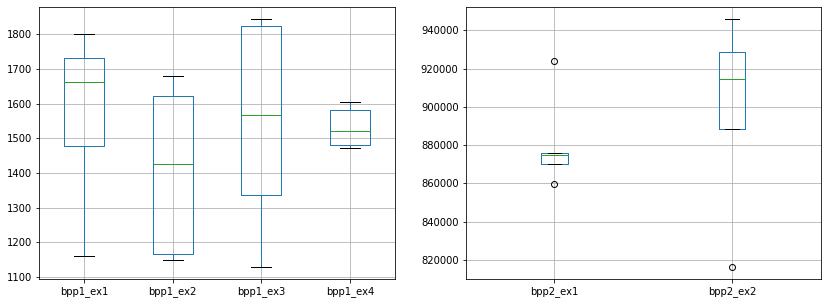

In [20]:
import matplotlib.pyplot as plt
import pandas

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

bpp1_ex1 = [1478, 1662, 1801, 1731, 1161]
bpp1_ex2 = [1149, 1681, 1166, 1623, 1426]
bpp1_ex3 = [1336, 1568, 1824, 1843, 1130]
bpp1_ex4 = [1472, 1482, 1521, 1582, 1606]

# p = 100 e = 0.9
# p = 100 e = 0.5
# p = 10 e = 0.9
# p = 10 e = 0.5

threed = np.zeroes(())

bpp1_df = pandas.DataFrame({
    "bpp1_ex1": [1478, 1662, 1801, 1731, 1161],
    "bpp1_ex2": [1149, 1681, 1166, 1623, 1426],
    "bpp1_ex3": [1336, 1568, 1824, 1843, 1130],
    "bpp1_ex4": [1472, 1482, 1521, 1582, 1606],
})

bpp1_df.boxplot(ax=ax[0])

bpp2_df = pandas.DataFrame({
    "bpp2_ex1": [875856, 923713, 859482, 870127, 875016],
    "bpp2_ex2": [816526, 888287, 945683, 914803, 928580],
})

bpp2_df.boxplot(ax=ax[1])

C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


     e    p  trial_1  trial_2  trial_3  trial_4  trial_5
0  0.9  100     1478     1662     1801     1731     1161
1  0.5  100     1149     1681     1166     1623     1426
2  0.9   10     1336     1568     1824     1843     1130
3  0.5   10     1472     1482     1521     1582     1606


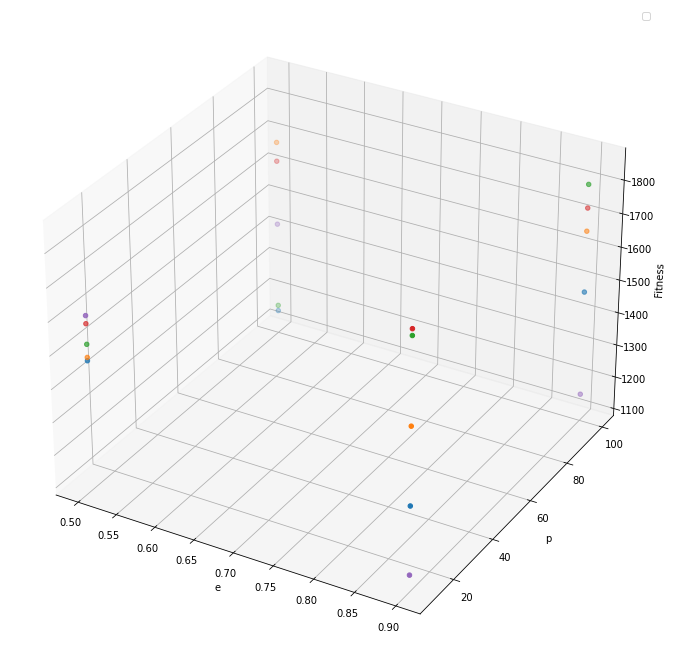

In [36]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

full_experiments = pandas.DataFrame({
    "e": [0.9, 0.5, 0.9, 0.5],
    "p": [100, 100, 10, 10],
    "trial_1": [1478, 1149, 1336, 1472],
    "trial_2": [1662, 1681, 1568, 1482],
    "trial_3": [1801, 1166, 1824, 1521],
    "trial_4": [1731, 1623, 1843, 1582],
    "trial_5": [1161, 1426, 1130, 1606]
})

print(full_experiments)

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)


ax.scatter(
    full_experiments["e"],
    full_experiments["p"],
    full_experiments["trial_1"]
)
ax.scatter(
    full_experiments["e"],
    full_experiments["p"],
    full_experiments["trial_2"]
)
ax.scatter(
    full_experiments["e"],
    full_experiments["p"],
    full_experiments["trial_3"]
)
ax.scatter(
    full_experiments["e"],
    full_experiments["p"],
    full_experiments["trial_4"]
)
ax.scatter(
    full_experiments["e"],
    full_experiments["p"],
    full_experiments["trial_5"]
)
ax.set_xlabel("e")
ax.set_ylabel("p")
ax.set_zlabel("Fitness")
ax.legend()

C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


     e    p  trial_1  trial_2  trial_3  trial_4  trial_5
0  0.9  100     1478     1662     1801     1731     1161
1  0.5  100     1149     1681     1166     1623     1426
2  0.9   10     1336     1568     1824     1843     1130
3  0.5   10     1472     1482     1521     1582     1606
4  0.7   60     1956     1569     1677     1791     1789


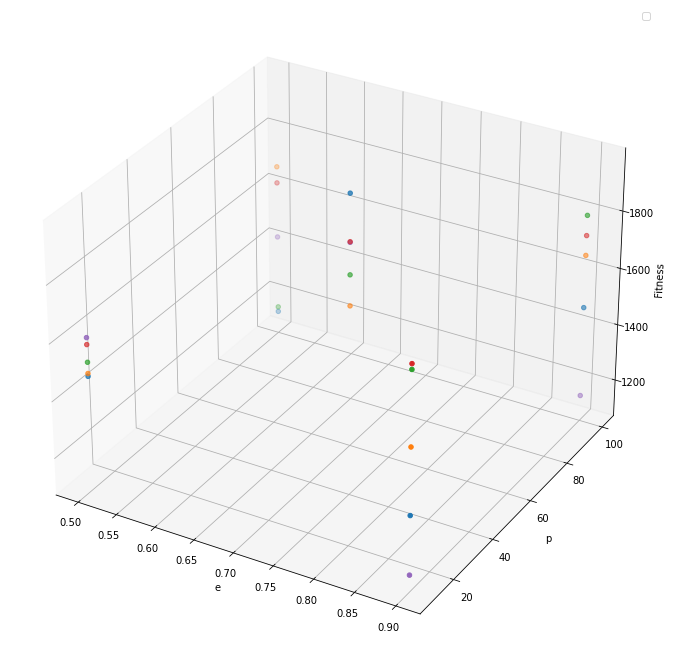

In [40]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

full_experiments = pandas.DataFrame({
    "e": [0.9, 0.5, 0.9, 0.5, 0.7],
    "p": [100, 100, 10, 10, 60],
    "trial_1": [1478, 1149, 1336, 1472, 1956],
    "trial_2": [1662, 1681, 1568, 1482, 1569],
    "trial_3": [1801, 1166, 1824, 1521, 1677],
    "trial_4": [1731, 1623, 1843, 1582, 1791],
    "trial_5": [1161, 1426, 1130, 1606, 1789],
})

print(full_experiments)

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)


ax.scatter(
    full_experiments["e"],
    full_experiments["p"],
    full_experiments["trial_1"]
)
ax.scatter(
    full_experiments["e"],
    full_experiments["p"],
    full_experiments["trial_2"]
)
ax.scatter(
    full_experiments["e"],
    full_experiments["p"],
    full_experiments["trial_3"]
)
ax.scatter(
    full_experiments["e"],
    full_experiments["p"],
    full_experiments["trial_4"]
)
ax.scatter(
    full_experiments["e"],
    full_experiments["p"],
    full_experiments["trial_5"]
)
ax.set_xlabel("e")
ax.set_ylabel("p")
ax.set_zlabel("Fitness")
ax.legend()

C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


      e    p  trial_1  trial_2  trial_3  trial_4  trial_5
0  0.90  100     1478     1662     1801     1731     1161
1  0.50  100     1149     1681     1166     1623     1426
2  0.90   10     1336     1568     1824     1843     1130
3  0.50   10     1472     1482     1521     1582     1606
4  0.70   60     1956     1569     1677     1791     1789
5  0.25  150     1374     1678     1204     1507     1449
6  0.70  150     1583     1465     1584      978     1539


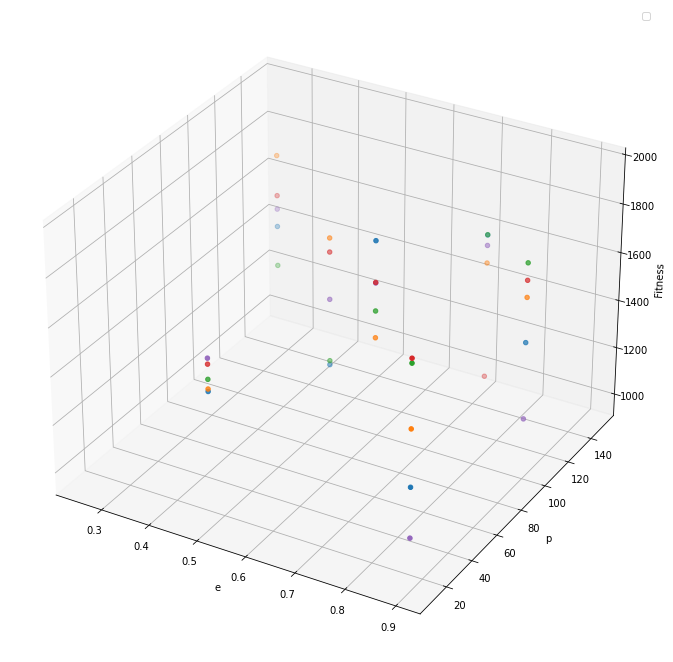

In [44]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

full_experiments = pandas.DataFrame({
    "e": [0.9, 0.5, 0.9, 0.5, 0.7, 0.25, 0.7],
    "p": [100, 100, 10, 10, 60, 150, 150],
    "trial_1": [1478, 1149, 1336, 1472, 1956, 1374, 1583],
    "trial_2": [1662, 1681, 1568, 1482, 1569, 1678, 1465],
    "trial_3": [1801, 1166, 1824, 1521, 1677, 1204, 1584],
    "trial_4": [1731, 1623, 1843, 1582, 1791, 1507, 978],
    "trial_5": [1161, 1426, 1130, 1606, 1789, 1449, 1539],
})

print(full_experiments)

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)


ax.scatter(
    full_experiments["e"],
    full_experiments["p"],
    full_experiments["trial_1"]
)
ax.scatter(
    full_experiments["e"],
    full_experiments["p"],
    full_experiments["trial_2"]
)
ax.scatter(
    full_experiments["e"],
    full_experiments["p"],
    full_experiments["trial_3"]
)
ax.scatter(
    full_experiments["e"],
    full_experiments["p"],
    full_experiments["trial_4"]
)
ax.scatter(
    full_experiments["e"],
    full_experiments["p"],
    full_experiments["trial_5"]
)
ax.set_xlabel("e")
ax.set_ylabel("p")
ax.set_zlabel("Fitness")
ax.legend()